In [ ]:
import Yukawa_SINDy as ys
import Yukawa3body as y3
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt

# Noise analysis for 3-body Yukawa system

Here, we load in the data used for all the noise cases used in this notebook. The data is a list of 200 `y3.Yukawa3body` objects with *no noise added*, and the data is *unsubtracted*.

In [117]:
# load in data
sim_list = y3.load_data('data/basic_noisy/analysis_trajectories')

In [149]:
noise_level = 1e-3
x_train = []
for sim in sim_list:
    # delete noise if present
    if sim.is_noisy:
        sim.delete_noise()
    # subtract data and add noise
    if not sim.is_subtracted:
        sim.subtract_data()
    if noise_level != 0:
        sim.add_gaussian_noise(noise_level=noise_level) # just use one noise level for now
    # collect data into list x_train for SINDy fitting
    x_train.append(sim.x)

In [150]:
sim_list[0].is_noisy

True

In [153]:
for sim in sim_list:
    sim.delete_noise()

In [199]:
all_data = np.concatenate([sim.x for sim in sim_list])
all_positions = np.concatenate([np.abs(position) for position in all_data[:,0::2]])
all_velocities = np.concatenate([np.abs(velocity) for velocity in all_data[:,1::2]])
avg_position = np.average(all_positions)
avg_velocity = np.average(all_velocities)
print("average magnitude of interparticle spacings:", avg_position)
print("average magnitude of differences in velocity:", avg_velocity)

average magnitude of interparticle spacings: 0.3731317925355648
average magnitude of differences in velocity: 8.87462815647504


In [194]:
np.max(all_positions),np.min(all_positions)

(2.4780761926705104, 3.4670794529789717e-07)

In [195]:
np.max(all_velocities),np.min(all_velocities)

(27.87314486877339, 1.0931972184380356e-05)

In [ ]:
import sklearn
zeros = np.zeros_like(all_positions)
sklearn.metrics.root_mean_squared_error(zeros, all_positions)

0.5240702948816783

In [190]:
sklearn.metrics.root_mean_squared_error(zeros, all_velocities)

10.592752726201555

In [186]:
all_positions[2]

-0.18521520958231585

In [181]:
np.average(1000000*[1,2,3])

2.0

In [ ]:
np.average(sim_list[0].x, axis=0)

array([-3.55896042e-01, -5.66128792e+00, -6.75543324e-04,  2.21850479e-01,
        5.96081544e-01,  1.54423535e+01,  5.33702632e-01,  1.15115134e+01,
       -2.40185502e-01, -9.78106561e+00, -5.33027088e-01, -1.17333639e+01])

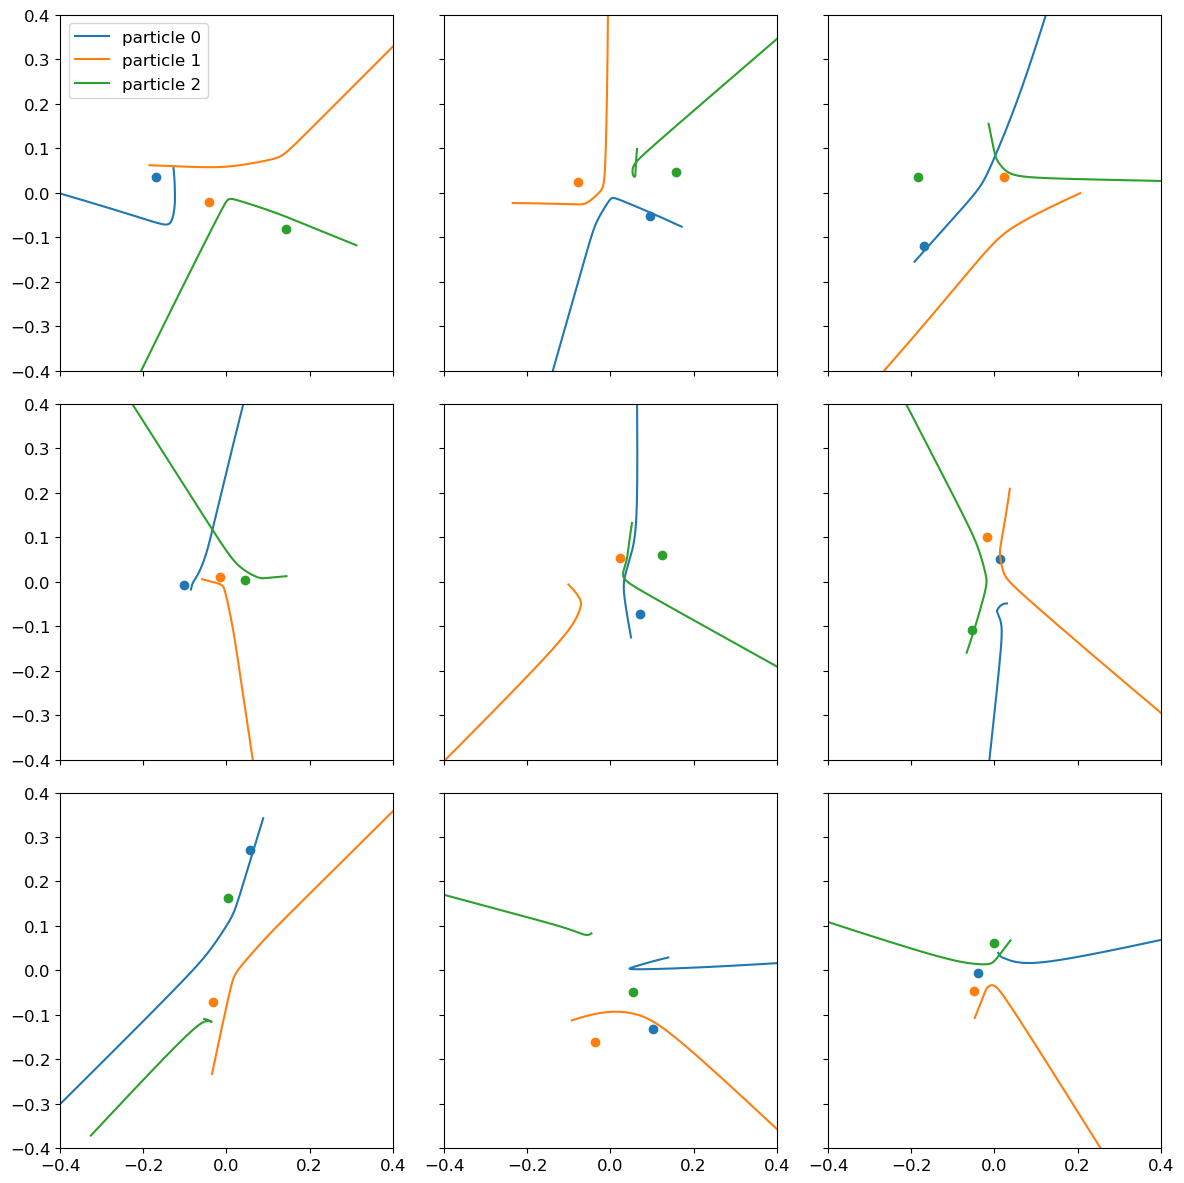

In [161]:
y3.plot_multiple(sim_list)

We can extract the simulation parameters used in this set by taking a look at the object attributes from the first element.

In [ ]:
# print simulation parameters
print("Number of trajectories:", len(sim_list))
print("Timestep duration:", sim_list[0].dt)
print("Duration:", sim_list[0].duration)
print("Number of timesteps (sanity check):", sim_list[0].x.shape[0])
print("Number of features (sanity check):", sim_list[0].x.shape[1])
print("Noisy:", sim_list[0].is_noisy)
print("Subtracted:", sim_list[0].is_subtracted)

Below is some code that will generate plots of 9 of the trajectories *with noise added*. 

In [ ]:
for sim in sim_list:
    if sim.is_noisy:
        sim.delete_noise()
    sim.add_gaussian_noise(noise_level=1e-4)

In [ ]:
y3.plot_multiple(sim_list[190:])

## `noise_level = 0`

We begin by looking at the clean data, with no Gaussian noise added. SINDy models were generated using the python script 'Code/data/basic_sindy_results_noisy.py'.

In [ ]:
# load in SINDy models for 0 noise case
nonoise_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00000/model_objs')
# remove models with threshold > 1 from list
nonoise_models = [model for model in nonoise_models if model.optimizer.threshold <= 1]

In [ ]:
ys.plot_complexity_objs(nonoise_models)

- course-graining (threshold scan from 0 to 0.45, increment 0.05) shows that the correct model is discovered some point between 0.3 and 0.35.
- I want to find the transition point from bad to good model to 3 significant figures, so I then did a more fine step of 0.005 and found that the discovered model becomes correct between 0.330 and 0.335
- Finally, investigating  between 0.328 and 0.337 by steps of 0.001 we find the critical threshold to be 0.334.
- This is not reflected in the plot above, which was made later.

Below are the models for `threshold=0.330` and `threshold=0.340`. We can see that in the 0.330 case, all of the trivial equations (of the form $\dot{x}=v$) are characterized by extremely large coefficients ($\sim 10^6$) for all the velocity features available to them *that are in the correct cartesian direction*. For example, the `(y0-y1)'`-equation has all 6 velocity features (of the form `(vxi-vxj)` and `(vyi-vyj)` for $i,j\in\{0,1,2|i\neq j\}$). On the other hand, the interesting equations (of the form $\dot{v}=f(x)$) are "correctly" discovered.

In [ ]:
for i in [33,34]:
    y3.print_SINDy_nice(nonoise_models[i], sim_list)

## `noise_level = 1e-5`

In [ ]:
noise00001_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00001/model_objs')

- The approximately correct model is discovered with a threshold of 0.40, where we only stepped the solver with 0.01 resolution.
- The complexity vs. threshold plot is shown here:

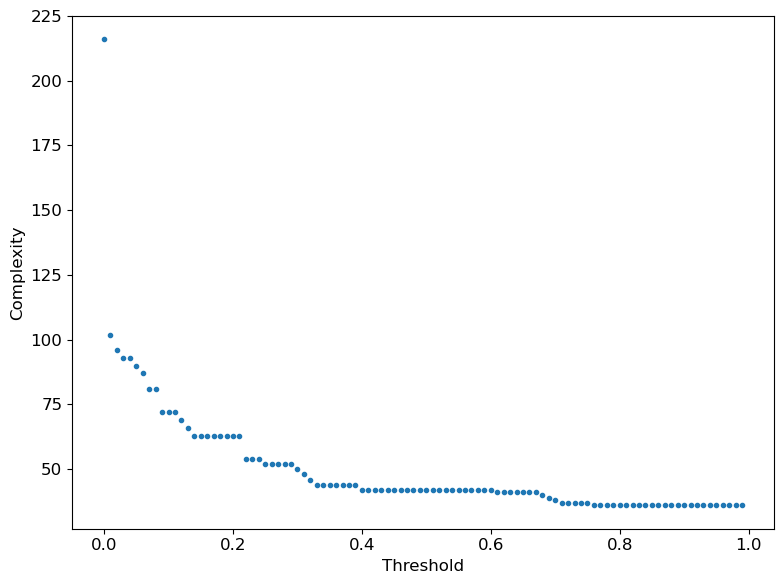

In [96]:
ys.plot_complexity_objs(noise00001_models)

We can look at the models around 0.4 to see how they evolve to the correct model.

In [ ]:
for i in [39,40]:
    y3.print_SINDy_nice(noise00001_models[i], sim_list)

- As we can see above, the only equation that is wrong with `threshold=0.39` is the `(y1-y2)'` equation, which proves to be an issue later as well (see below).
- It could be interesting to investigate whether that is a problem with this particular set of trajectories. There is no obvious reason why that particular equation would be an issue.

## `noise_level = 2e-5`

In [ ]:
noise00002_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00002/model_objs')
noise00002_models = [model for model in noise00002_models if model.optimizer.threshold <= 1]

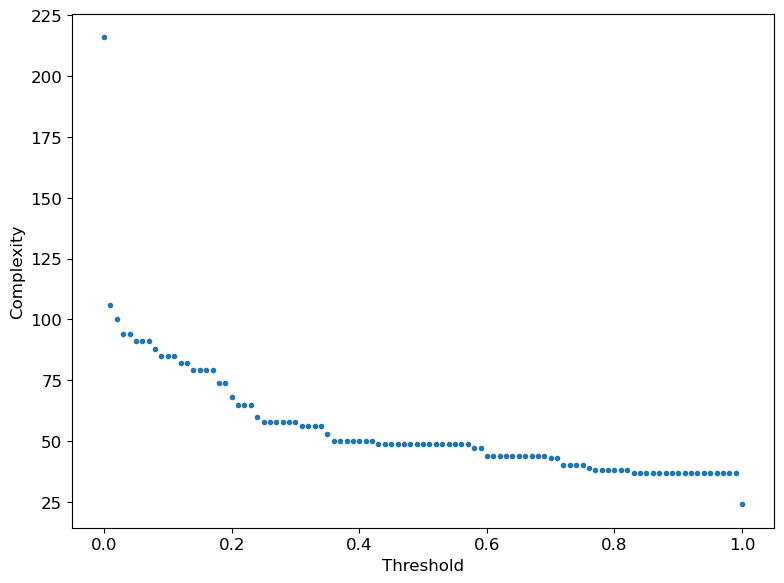

In [97]:
ys.plot_complexity_objs(noise00002_models)

- Interestingly, the steps here are much more small and incremental than in the no noise case
- Here, the correct model is *not* discovered. We can check around the correct complexity value and see how close we get.
- The model generated with threshold=0.64 comes the closest to the true model without zeroing out any coefficients shown below

In [125]:
for i in [57,58,60]:
    y3.print_SINDy_nice(noise00002_models[i], sim_list)

noise level: 0
number of trajectories: 200
STLSQ threshold: 0.5700000000000001
complexity: 49
(x0-x1)'      = 1.000 vx0-vx1

(vx0-vx1)'    = 2.207 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + 1.992 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)
              + -1.070 (x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)
              + -0.997 (x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)^(3/2)
              + -1.042 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)
              + -0.998 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)^(3/2)

(y0-y1)'      = 1.000 vy0-vy1

(vy0-vy1)'    = 2.161 (y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + 1.994 (y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)
              + -1.085 (y1-y2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)
              + -0.996

- In all three cases shown here, we can see that the `(vx1-vx2)'` equation contains extraneous terms with very large coefficients
- In the first case with `threshold=0.57` we can see that there are no equations in which all the coefficients are zero. Problematic equations are only the `(vx1-vx2)'` equation, the `(y1-y2)'` equation, and the `(vy2-vy0)` equation which contain extraneous terms.
- At `threshold=0.58`, we can see that instead of settling into the correct form, thresholding forces the `(y1-y2)'`-equation to be zero, while the extraneous terms remain in the `(vx1-vx2)'` and `(vy2-vy0)` equations.
- In the third case, `threshold=0.60`, we can see that the extraneous terms in the `(vy2-vy0)'` equation go to zero.

## `noise_level = 3e-5`

In [ ]:
noise00003_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00003/model_objs')
noise00003_models = [model for model in noise00002_models if model.optimizer.threshold <= 1]

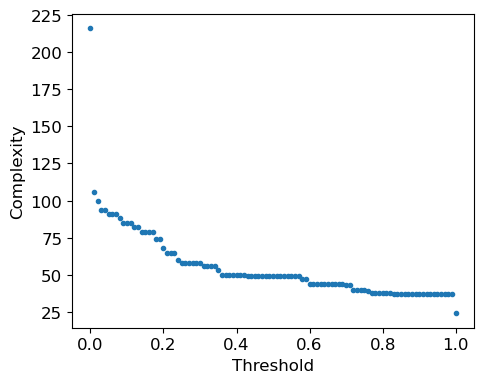

In [98]:
ys.plot_complexity_objs(noise00003_models, figsize=(5,4))

The complexity vs. threshold looks exactly the same as the `noise_level=2e-5` case. There is a quick check that I can do to verify this.

In [99]:
def check_equations(models1, models2):
    '''
    Description: Checks to see if the equations of two lists of ps.SINDy() models are the same.
    '''
    if len(models1) != len(models2):
        raise ValueError("Lists of models must be of equal length")
    for i in range(len(models1)):
        Equation_check = np.array(models1[i].equations())==np.array(models2[i].equations())
        TrueMat = np.array(12*[True])
        if not np.array_equal(Equation_check, TrueMat):
            print("Equations do not match at index", i)
            return False
    print("All model equations match")
    return True

In [100]:
check_equations(noise00002_models, noise00003_models)

All model equations match


True

So, even though we slightly increased the noise level, SINDy generates *the same sequence of 100 models* from `threshold=0` to `threshold=0.99`.

I speculate that this could be due to the fact that the increase in noise is just too small.

## `noise_level = 4e-5`

In [ ]:
noise00004_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00004/model_objs')
noise00004_models = [model for model in noise00002_models if model.optimizer.threshold <= 1]

In [ ]:
ys.plot_complexity_objs(noise00004_models, figsize=(5,4))

In [ ]:
y3.print_SINDy_nice(noise00004_models[72], sim_list)

In [102]:
check_equations(noise00003_models, noise00004_models)

All model equations match


True

The same is true here as for above, the equations are all the same and SINDy has generated the same sequence of 100 models.

## `noise_level = 1e-4`

In [ ]:
noise00010_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00010/model_objs')
noise00010_models = [model for model in noise00002_models if model.optimizer.threshold <= 1]

In [ ]:
ys.plot_complexity_objs(noise00010_models, figsize=(5,4))

In [ ]:
y3.print_SINDy_nice(noise00010_models[72], sim_list)

In [103]:
check_equations(noise00004_models, noise00010_models)

All model equations match


True

The same is true here, even when we increase by *an order of magnitude*, SINDy generates the same sequence of 100 models.

## `noise_level=5e-4`

In [107]:
noise00050_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00050/model_objs')
noise00050_models_to1 = [model for model in noise00050_models if model.optimizer.threshold <= 1]

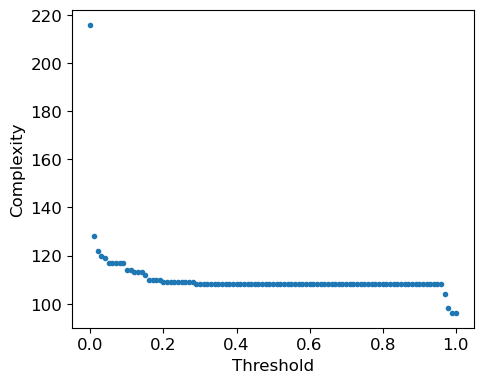

In [108]:
ys.plot_complexity_objs(noise00050_models_to1, figsize=(5,4))

In [112]:
check_equations(noise00010_models, noise00050_models_to1)

Equations do not match at index 0


False

Here, we finally found a new sequence of model that SINDy has discovered. Once again, this could be due to the numbers being so small, but here we have found a new sequence of models. Further, a threshold of 1 is not enough to find a model with the right complexity, so we need to increase the threshold higher to see if we can find any better model.

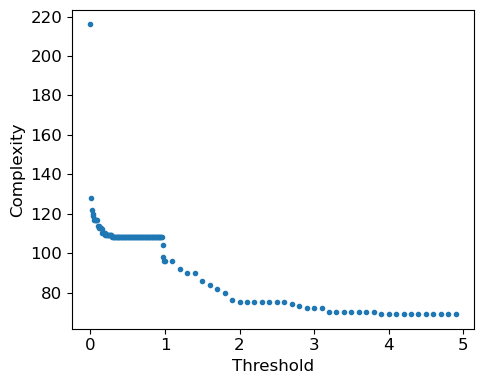

In [113]:
ys.plot_complexity_objs(noise00050_models, figsize=(5,4))

In [114]:
len(noise00050_models)

140

In [ ]:
y3.print_SINDy_nice(noise00050_models[99], sim_list)

noise level: 0
number of trajectories: 200
STLSQ threshold: 0.99
complexity: 96
(x0-x1)'      = 57.962 vx0-vx1
              + -4.310 vy0-vy1
              + 56.962 vx1-vx2
              + -4.310 vy1-vy2
              + 56.962 vx2-vx0
              + -4.310 vy2-vy0

(vx0-vx1)'    = -230.274 vx0-vx1
              + 566.965 vy0-vy1
              + -228.365 vx1-vx2
              + 566.886 vy1-vy2
              + -228.439 vx2-vx0
              + 567.224 vy2-vy0
              + -7.403 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + 2.093 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)
              + -36.157 (x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)
              + -38.862 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)

(y0-y1)'      = 40.493 vx0-vx1
              + 98.315 vy0-vy1
              + 40.493 vx1-vx2
              + 97.315 vy1-vy2
              + 40.493 vx2-vx0
              + 97.

Interestingly, on the last model we just have all of the linear terms active and *none* of the Yukawa terms.

In [123]:
noise00050_models[-1].get_feature_names()

['vx0-vx1',
 'vy0-vy1',
 'vx1-vx2',
 'vy1-vy2',
 'vx2-vx0',
 'vy2-vy0',
 '(x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)',
 '(y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)',
 '(x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)',
 '(y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)',
 '(x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)',
 '(y1-y2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)',
 '(x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)^(3/2)',
 '(y1-y2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)^(3/2)',
 '(x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)',
 '(y2-y0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)',
 '(x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)^(3/2)',
 '(y2-y0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)^(3/2)']

In [121]:
print(noise00050_models[-1].coefficients())

[[   57.67496437     0.            56.67505654     0.
     56.67504283     0.             0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.
      0.             0.        ]
 [ 3754.72700755  1339.95609647  3753.80417249  1340.08081253
   3753.32339894  1338.63644171     0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.
      0.             0.        ]
 [   40.49300784    98.315114      40.49295222    97.3151663
     40.49294063    97.3151146      0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.
      0.             0.        ]
 [-2147.249247     138.80280504 -2147.91497901   138.49950561
  -2148.14209726   138.40998594     0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.
      0.      

## Images for poster

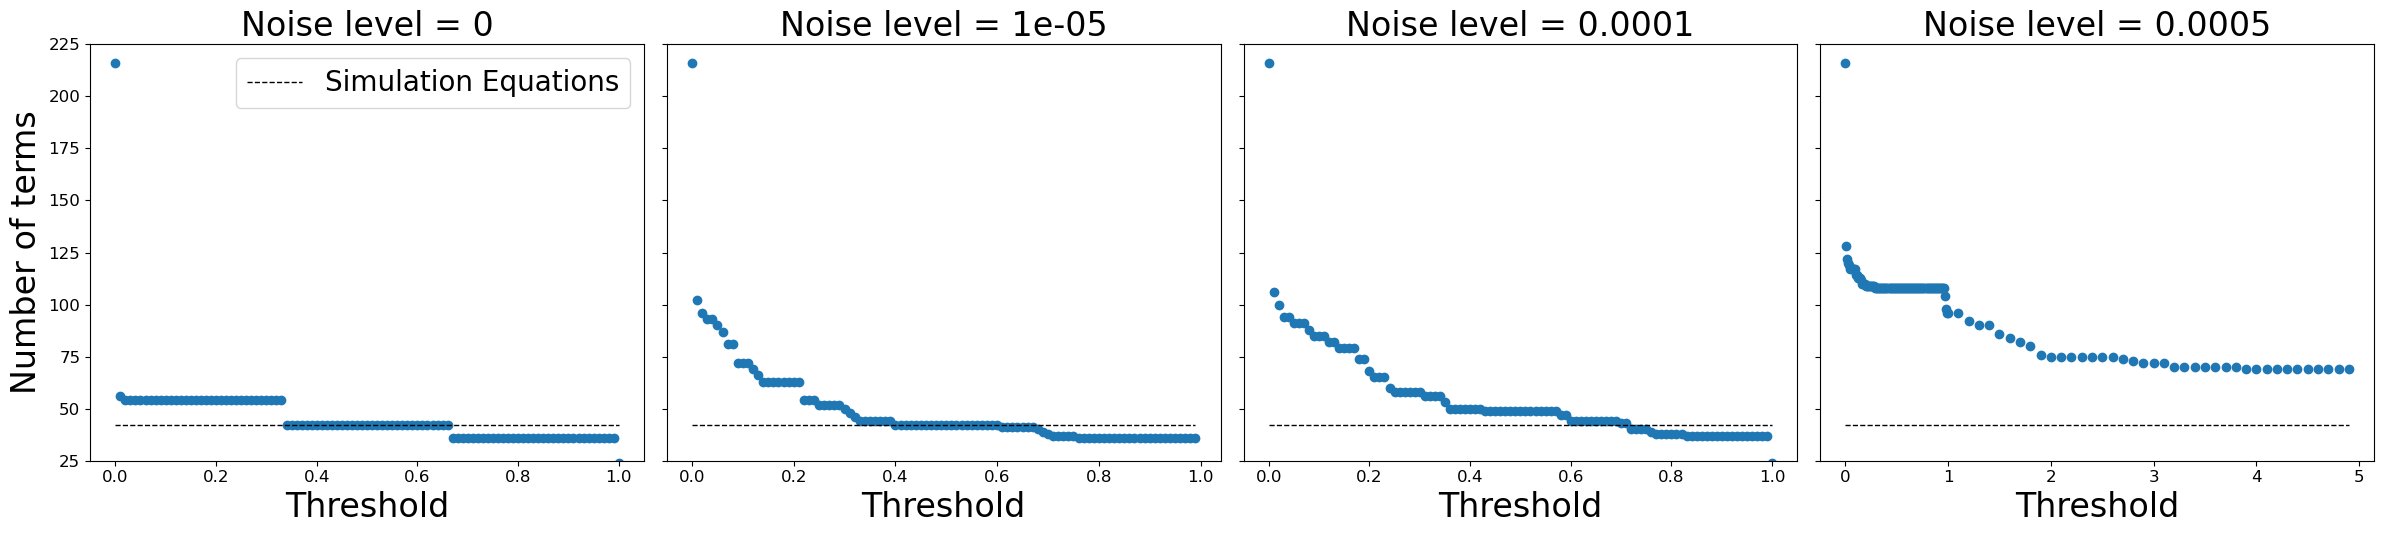

In [223]:
heading_fontsize = 24
noise_models = [nonoise_models,noise00001_models, noise00010_models, noise00050_models]#, noise00003_models, noise00004_models]
noise_levels = [0, 1e-5, 1e-4, 5e-4]
figsize = (24,5.5)
plt.rcParams['font.size'] = 12
fig, axs = plt.subplots(1, len(noise_models), sharey=True,figsize=figsize)
for i, model_list in enumerate(noise_models):
    # extract hparams and complexity from each model
    thresholds = np.array([model.optimizer.threshold for model in model_list])
    complexities = np.array([model.complexity for model in model_list])
    # plot complexity vs. thresholds
    axs[i].plot(thresholds, complexities, 'o')
    axs[i].set_title('Noise level = ' + str(noise_levels[i]), fontsize=heading_fontsize)
    axs[i].set_ylim(25,225)
    axs[i].set_xlabel('Threshold', fontsize=heading_fontsize)
    axs[i].hlines(42, 0, np.max(thresholds), colors='k', linestyles='dashed', lw=1, label="Simulation Equations")
axs[0].legend(fontsize=heading_fontsize-4)
axs[0].set_ylabel('Number of terms', fontsize=heading_fontsize)
fig.tight_layout()
fig.show()

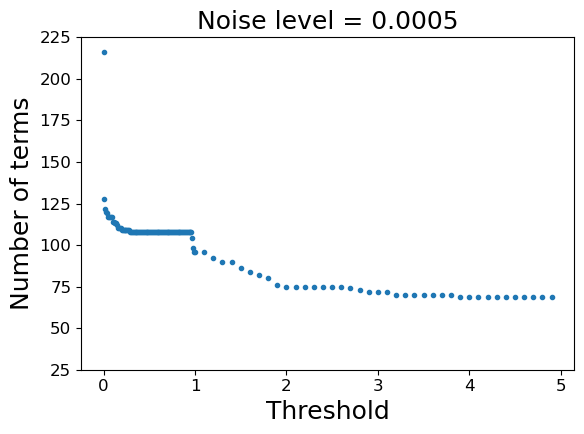

In [142]:
figsize = (6,4.5)
label_fontsize = 18
noise_level = 0.0005
fig, axs = plt.subplots(1, 1, sharex=True,figsize=figsize)
# extract hparams and complexity from each model
thresholds = np.array([model.optimizer.threshold for model in noise00050_models])
complexities = np.array([model.complexity for model in noise00050_models])
# plot complexity vs. thresholds
axs.plot(thresholds, complexities, '.')
axs.set_ylabel('Number of terms', fontsize=label_fontsize)
axs.set_title('Noise level = ' + str(noise_level), fontsize=label_fontsize)
axs.set_ylim(25,225)
axs.set_xlabel('Threshold', fontsize=label_fontsize)
fig.tight_layout()
fig.show()

In [129]:
len(nonoise_models[0].get_feature_names())

18

In [130]:
nonoise_models[0].get_feature_names()

['vx0-vx1',
 'vy0-vy1',
 'vx1-vx2',
 'vy1-vy2',
 'vx2-vx0',
 'vy2-vy0',
 '(x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)',
 '(y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)',
 '(x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)',
 '(y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)',
 '(x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)',
 '(y1-y2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)',
 '(x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)^(3/2)',
 '(y1-y2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)^(3/2)',
 '(x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)',
 '(y2-y0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)',
 '(x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)^(3/2)',
 '(y2-y0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)^(3/2)']